In [ ]:
import os,yaml,argparse
import pytorch_lightning as pl
from tbsim.utils.batch_utils import set_global_batch_type
from tbsim.utils.trajdata_utils import set_global_trajdata_batch_env, set_global_trajdata_batch_raster_cfg
from datetime import  datetime
from tbsim.datasets.trajdata_datamodules import PassUnifiedDataModule
from configs.custom_config import dict_to_config,ConfigBase
from tbsim.configs.base import ExperimentConfig
from utils.trainer_utils import prepare_trainer_and_data
from tbsim.utils.trajdata_utils import set_global_trajdata_batch_env, set_global_trajdata_batch_raster_cfg
from tbsim.utils.batch_utils import batch_utils
from tbsim.utils.batch_utils import set_global_batch_type
from tbsim.utils.config_utils import translate_pass_trajdata_cfg

from tbsim.utils.scene_edit_utils import UnifiedRenderer
from tbsim.utils.batch_utils import batch_utils
import matplotlib.pyplot as plt
import numpy as np
from tbsim.utils.scene_edit_utils import get_agt_color
COLORS = {
    "agent_contour": "#247BA0",
    "agent_fill": "#56B1D8",
    "ego_contour": "#911A12",
    "ego_fill": "#FE5F55",
}

import tbsim.utils.geometry_utils as GeoUtils

from l5kit.geometry import transform_points
import matplotlib.patches as patches


In [2]:
parser = argparse.ArgumentParser(description="Training Script")
parser.add_argument("--config", type=str, default="./config.yaml", help="Path to YAML config")
args = parser.parse_args([])
with open(args.config, "r") as f:
    config_dict = yaml.safe_load(f)
train_config = dict_to_config(ConfigBase, config_dict.get("train", {}))
env_config = dict_to_config(ConfigBase, config_dict.get("env", {}))
algo_config = dict_to_config(ConfigBase, config_dict.get("algo", {}))
default_config = ExperimentConfig(
    train_config=train_config,
    env_config=env_config,
    algo_config=algo_config,
    registered_name=config_dict.get("registered_name", "default_experiment"),
)
  
default_config.lock()
cfg = default_config
pl.seed_everything(default_config.seed)
set_global_batch_type("trajdata")
set_global_trajdata_batch_env(default_config.train.trajdata_source_train[0])
set_global_trajdata_batch_raster_cfg(default_config.env.rasterizer)

trajdata_config = translate_pass_trajdata_cfg(cfg)
datamodule = PassUnifiedDataModule(trajdata_config, cfg.train)
datamodule.setup()
dataset = datamodule.train_dataset
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
raster_size = trajdata_config.raster_size
px_per_m = int(1/trajdata_config.pixel_size)
renderer = UnifiedRenderer(dataset, raster_size=raster_size, resolution=px_per_m)

Seed set to 1


registered_name: default_experiment
data_cfg.trajdata_predict_types ['vehicle']
{'cache_location': '~/my_custom_cache_location', 'desired_data': ['nusc_trainval-train', 'nusc_trainval-train_val'], 'desired_dt': 0.1, 'future_sec': (5.2, 5.2), 'history_sec': (3.0, 3.0), 'data_dirs': <configs.custom_config.ConfigBase object at 0x755ed745d070>, 'only_types': [<AgentType.VEHICLE: 1>], 'only_predict': [<AgentType.VEHICLE: 1>], 'agent_interaction_distances': defaultdict(<function PassUnifiedDataModule.setup.<locals>.<lambda> at 0x755e187d45e0>, {}), 'incl_raster_map': True, 'raster_map_params': {'px_per_m': 2, 'map_size_px': 224, 'return_rgb': False, 'offset_frac_xy': [-0.5, 0.0], 'no_map_fill_value': -1.0}, 'incl_vector_map': True, 'centric': 'agent', 'scene_description_contains': None, 'standardize_data': True, 'verbose': True, 'max_agent_num': None, 'num_workers': 24, 'rebuild_cache': False, 'rebuild_maps': False, 'extras': {'closest_lane_point': <function get_closest_lane_point_wrapper.<l

/home/visier/ctg_project/trajdata/src/trajdata/dataset_specific/nusc/nusc_dataset.py:62: UserWarning: Beware, nusc_test has no annotations!
  warnings.warn("Beware, nusc_test has no annotations!")
Calculating Agent Data (Serially): 100%|██████████| 700/700 [00:00<00:00, 132092.18it/s]

700 scenes in the scene index.



Structuring Agent Data Index: 100%|██████████| 700/700 [00:00<00:00, 72075.92it/s]

Loading data for matched scene tags: ['nusc_trainval-val-boston', 'nusc_trainval-val-singapore']



Calculating Agent Data (Serially): 100%|██████████| 150/150 [00:00<00:00, 111768.63it/s]

150 scenes in the scene index.



Structuring Agent Data Index: 100%|██████████| 150/150 [00:00<00:00, 55411.80it/s]


'raster_map_params': {
'px_per_m': 2, 
'map_size_px': 224, 
'return_rgb': False, 
'offset_frac_xy': [-0.5, 0.0], 
'no_map_fill_value': -1.0
}


In [3]:



batch = next(iter(train_loader))
batch = batch_utils().parse_batch(batch)
batch.keys()


dict_keys(['data_idx', 'scene_ts', 'dt', 'agent_name', 'agent_type', 'curr_agent_state', 'agent_hist', 'agent_hist_extent', 'agent_hist_len', 'agent_fut', 'agent_fut_extent', 'agent_fut_len', 'num_neigh', 'neigh_indices', 'neigh_types', 'neigh_hist', 'neigh_hist_extents', 'neigh_hist_len', 'neigh_fut', 'neigh_fut_extents', 'neigh_fut_len', 'robot_fut_len', 'map_names', 'maps', 'maps_resolution', 'vector_maps', 'rasters_from_world_tf', 'agents_from_world_tf', 'scene_ids', 'history_pad_dir', 'extras', 'image', 'drivable_map', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_speeds', 'history_availabilities', 'curr_speed', 'centroid', 'yaw', 'type', 'extent', 'raster_from_agent', 'agent_from_raster', 'raster_from_world', 'agent_from_world', 'world_from_agent', 'all_other_agents_indices', 'all_other_agents_history_positions', 'all_other_agents_history_yaws', 'all_other_agents_history_speeds', 'all_other_agents_history_availabilities'

In [18]:
ras_pos = batch['centroid']#[0,:]
ras_pos


tensor([[1004.6430, 1636.8990],
        [ 406.3850, 1939.7469],
        [ 880.0680, 1345.0120],
        [ 662.5640, 1200.8730]])

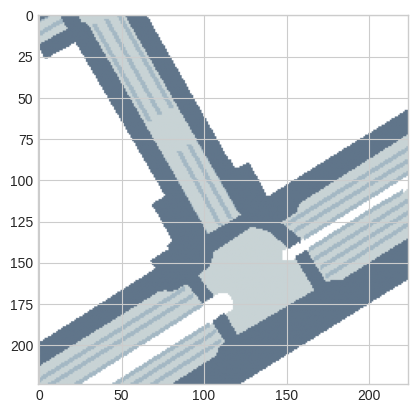

In [17]:

%matplotlib inline
scene_name =batch['scene_ids'][0]
state_im, raster_from_world = renderer.render(
        ras_pos=ras_pos,
        # ras_yaw=scene_data["yaw"][0, t],
        ras_yaw=0,
        # ras_yaw=np.pi,
        scene_name=scene_name
    )


# fill_colors = np.array([get_agt_color(aidx) for aidx in range(1)])
# outline_colors = np.array([COLORS["agent_contour"] for _ in range(1)])
# outline_widths = np.array([0.5 for _ in range(1)])
# mark_agents = []
# outline_colors=outline_colors.tolist()        
# outline_widths=outline_widths.tolist()
# fill_colors=fill_colors.tolist()
fig, ax = plt.subplots()
ax.imshow(state_im)


In [ ]:
frames = range(0, batch["centroid"].shape[1], 1)

fig, ax = plt.subplots()
ax.imshow(state_im)
traj_alpha = 0.9 # 0.6 for GPT pair rules plotting
traj_line_width = 1.2 * 2 # 0.7 * linewidth for GPT pair rules plotting
traj_use_agt_color = False
traj_agt_color = None
traj_z = None


torch.Size([3, 3])

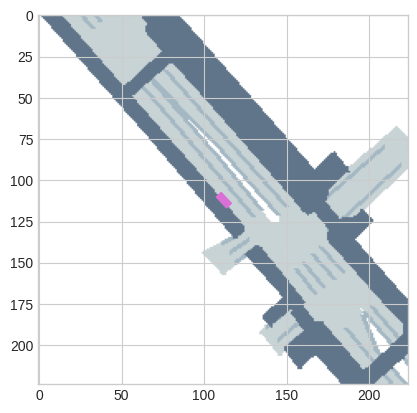

In [210]:
# fig, ax = plt.subplots()
pos= batch["centroid"][0,:].cpu().numpy()
pos = pos[None, :] 
yaw = batch['yaw'][0].cpu().numpy()
yaw = np.array([yaw])
extent = batch['extent'][0,:2].cpu().numpy()
extent = extent[None, :] 

boxes = GeoUtils.get_box_world_coords_np(pos, yaw, extent)
boxes_raster = transform_points(boxes, raster_from_world)
boxes_raster_1 = boxes.reshape((-1, 4, 2))
mark_agents = dict()
fig, ax = plt.subplots()


for bi, b in enumerate(boxes_raster):
    cur_fill_color = get_agt_color(bi) if fill_colors is None else fill_colors[bi]
    cur_outline_color = "grey" if outline_colors is None else outline_colors[bi]
    cur_outline_width = 0.5 if outline_widths is None else outline_widths[bi]
    
    rect = patches.Polygon(b, fill=True, color=cur_fill_color, zorder=3)
    rect_border = patches.Polygon(b*5, fill=False, color=cur_outline_color, zorder=3, linewidth=cur_outline_width)
    image = batch['maps'][0].permute(1,2,0).cpu().numpy()*0.5+0.5
    ax.add_patch(rect)
    ax.add_patch(rect_border)
    ax.imshow(state_im)
    
raster_from_agent = batch['raster_from_agent'][0]


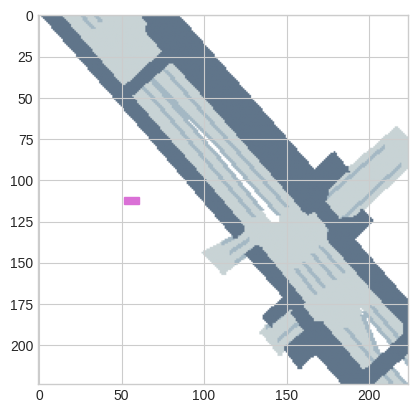

In [214]:
pos= batch["centroid"][0,:].cpu().numpy()
pos = pos[None, :] 
yaw = batch['yaw'][0].cpu().numpy()
yaw = np.array([yaw])
extent = batch['extent'][0,:2].cpu().numpy()
extent = extent[None, :] 
r_w = batch['raster_from_world'][0]

boxes = GeoUtils.get_box_world_coords_np(pos, yaw, extent)
boxes_raster = transform_points(boxes, r_w)
boxes_raster_1 = boxes.reshape((-1, 4, 2))
mark_agents = dict()
fig, ax = plt.subplots()


for bi, b in enumerate(boxes_raster):
    cur_fill_color = get_agt_color(bi) if fill_colors is None else fill_colors[bi]
    cur_outline_color = "grey" if outline_colors is None else outline_colors[bi]
    cur_outline_width = 0.5 if outline_widths is None else outline_widths[bi]
    
    rect = patches.Polygon(b, fill=True, color=cur_fill_color, zorder=3)
    rect_border = patches.Polygon(b*5, fill=False, color=cur_outline_color, zorder=3, linewidth=cur_outline_width)
    image = batch['maps'][0].permute(1,2,0).cpu().numpy()*0.5+0.5
    ax.add_patch(rect)
    ax.add_patch(rect_border)
    ax.imshow(state_im)